In [1]:
import numpy as np
from collections import defaultdict, Counter
from sklearn.metrics import accuracy_score, classification_report
import pickle
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE = "/content/drive/MyDrive/NLP-POS/data/processed"

# Numpy datasetler
X_train = np.load(f"{BASE}/X_train.npy", allow_pickle=True)
y_train = np.load(f"{BASE}/y_train.npy", allow_pickle=True)

X_dev = np.load(f"{BASE}/X_dev.npy", allow_pickle=True)
y_dev = np.load(f"{BASE}/y_dev.npy", allow_pickle=True)

X_test = np.load(f"{BASE}/X_test.npy", allow_pickle=True)
y_test = np.load(f"{BASE}/y_test.npy", allow_pickle=True)

# Mapping dosyaları
with open(f"{BASE}/word2id.pkl", "rb") as f:
    word2id = pickle.load(f)

with open(f"{BASE}/tag2id.pkl", "rb") as f:
    tag2id = pickle.load(f)

with open(f"{BASE}/id2word.pkl", "rb") as f:
    id2word = pickle.load(f)

with open(f"{BASE}/id2tag.pkl", "rb") as f:
    id2tag = pickle.load(f)

with open(f"{BASE}/max_len.json", "r") as f:
    import json
    max_len = json.load(f)

print("Train size:", len(X_train))
print("Dev size:", len(X_dev))
print("Test size:", len(X_test))
print("Max sentence length:", max_len)
print("Unique words:", len(word2id))
print("Unique tags:", len(tag2id))

Train size: 14187
Dev size: 1400
Test size: 427
Max sentence length: {'max_len': 56}
Unique words: 46133
Unique tags: 17


In [6]:
# PAD tag belirle
if "PAD" in tag2id:
    PAD_TAG = "PAD"
elif "<PAD>" in tag2id:
    PAD_TAG = "<PAD>"
else:
    # yoksa otomatik oluştur
    PAD_TAG = "<PAD>"
    pad_id = max(tag2id.values()) + 1
    tag2id[PAD_TAG] = pad_id
    id2tag[pad_id] = PAD_TAG

PAD_ID = tag2id[PAD_TAG]

def idx_seq_to_tags(seq):
    tags = []
    for i in seq:
        i = int(i)
        if i == -1:
            tags.append(PAD_TAG)   # pad'i tag adıyla değiştir
        else:
            tags.append(id2tag[i])
    return tags

def idx_seq_to_words(seq):
    return [id2word[int(i)] for i in seq]

train_words = [idx_seq_to_words(x) for x in X_train]
train_tags  = [idx_seq_to_tags(y) for y in y_train]

dev_words = [idx_seq_to_words(x) for x in X_dev]
dev_tags  = [idx_seq_to_tags(y) for y in y_dev]

test_words = [idx_seq_to_words(x) for x in X_test]
test_tags  = [idx_seq_to_tags(y) for y in y_test]

print("Padding ID:", PAD_ID, "Tag:", PAD_TAG)

Padding ID: 17 Tag: <PAD>


In [7]:
import math

class WeightedHMM:
    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.transition = defaultdict(lambda: defaultdict(float))
        self.emission = defaultdict(lambda: defaultdict(float))
        self.tag_count = Counter()
        self.word_count = Counter()
        self.labels = set()

    def fit(self, sentences, tags):
        for sentence, tag_seq in zip(sentences, tags):
            prev_tag = "<s>"
            self.tag_count[prev_tag] += 1

            for word, tag in zip(sentence, tag_seq):
                self.labels.add(tag)
                self.tag_count[tag] += 1
                self.word_count[word] += 1

                self.transition[prev_tag][tag] += 1
                self.emission[tag][word] += 1

                prev_tag = tag

            self.transition[prev_tag]["</s>"] += 1

        # Laplace smoothing log-prob
        for prev in self.transition:
            total = sum(self.transition[prev].values()) + self.smoothing * len(self.labels)
            for tag in self.labels.union({"</s>"}):
                self.transition[prev][tag] = math.log(
                    (self.transition[prev][tag] + self.smoothing) / total
                )

        for tag in self.emission:
            total = sum(self.emission[tag].values()) + self.smoothing * len(self.word_count)
            for word in self.word_count:
                self.emission[tag][word] = math.log(
                    (self.emission[tag][word] + self.smoothing) / total
                )

    def predict(self, sentence):
        V = [{}]
        path = {}

        for tag in self.labels:
            V[0][tag] = self.transition["<s>"][tag] + self.emission[tag].get(sentence[0], -15)
            path[tag] = [tag]

        for t in range(1, len(sentence)):
            V.append({})
            new_path = {}

            for tag in self.labels:
                (prob, best_prev) = max(
                    (V[t-1][pt] + self.transition[pt][tag] +
                     self.emission[tag].get(sentence[t], -15), pt)
                    for pt in self.labels
                )
                V[t][tag] = prob
                new_path[tag] = path[best_prev] + [tag]

            path = new_path

        (prob, best_tag) = max((V[len(sentence)-1][t], t) for t in self.labels)
        return path[best_tag]

In [8]:
hmm = WeightedHMM(smoothing=1.0)
hmm.fit(train_words + dev_words, train_tags + dev_tags)

In [10]:
from sklearn.metrics import f1_score, classification_report

y_true = []
y_pred = []

for words, tags in zip(test_words, test_tags):
    pred = hmm.predict(words)
    y_true.extend(tags)
    y_pred.extend(pred)

# Classification report and F1
print(classification_report(y_true, y_pred, zero_division=0))
print("Macro F1:", f1_score(y_true, y_pred, average='macro', zero_division=0))
print("Micro F1:", f1_score(y_true, y_pred, average='micro', zero_division=0))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted', zero_division=0))

              precision    recall  f1-score   support

       <PAD>       1.00      1.00      1.00     12427
         ADJ       0.81      0.76      0.78       635
         ADP       0.95      0.99      0.97      1807
         ADV       0.97      0.88      0.92       402
         AUX       0.92      0.92      0.92       313
       CCONJ       0.97      0.89      0.93       378
         DET       0.92      0.98      0.95      1637
        INTJ       0.00      0.00      0.00         1
        NOUN       0.91      0.89      0.90      2132
         NUM       0.98      0.69      0.81       226
        PART       0.00      0.00      0.00         1
        PRON       0.88      0.84      0.86       429
       PROPN       0.65      0.82      0.73       804
       PUNCT       0.98      1.00      0.99      1195
       SCONJ       0.86      0.93      0.89       322
         SYM       0.94      0.68      0.79        25
        VERB       0.92      0.79      0.85      1136
           X       0.25    

In [12]:
!pip install dill
import dill
import os

MODEL_DIR = "/content/drive/MyDrive/NLP-POS/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# HMM modelini kaydet
with open(os.path.join(MODEL_DIR, "hmm_model.pkl"), "wb") as f:
    dill.dump(hmm, f)

print("HMM model saved at:", os.path.join(MODEL_DIR, "hmm_model.pkl"))

HMM model saved at: /content/drive/MyDrive/NLP-POS/models/hmm_model.pkl


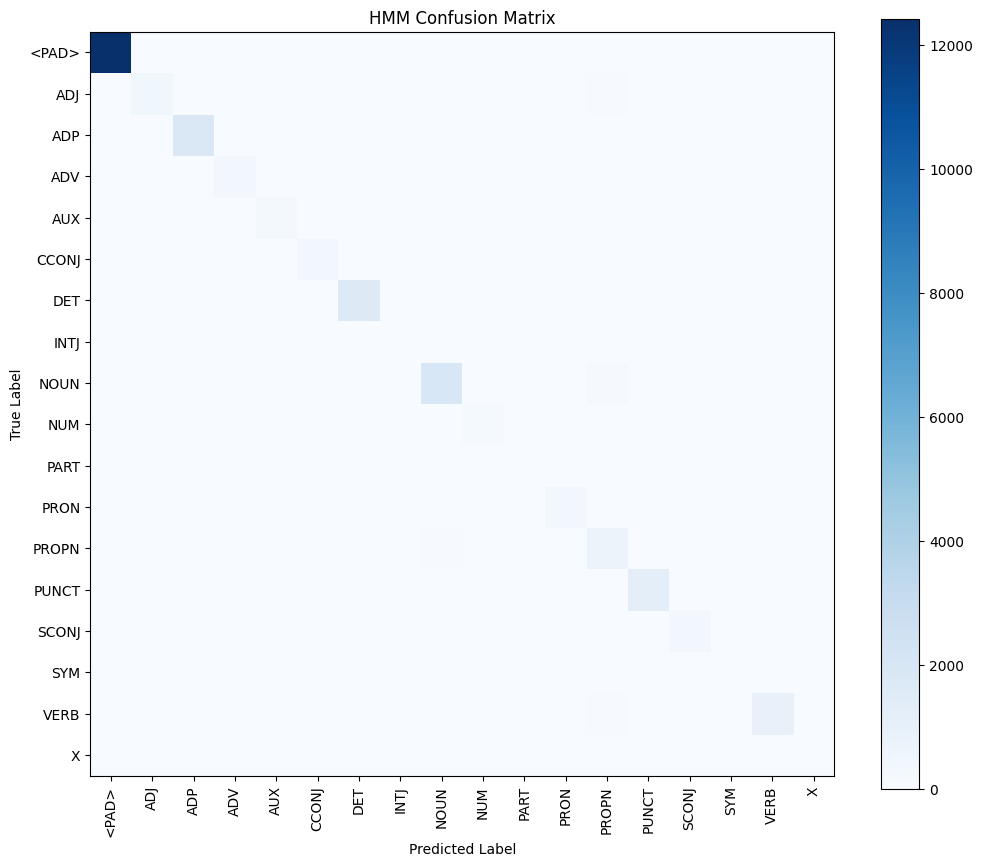

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Label listesi, PAD dahil
labels = sorted(list(set(y_true)))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("HMM Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

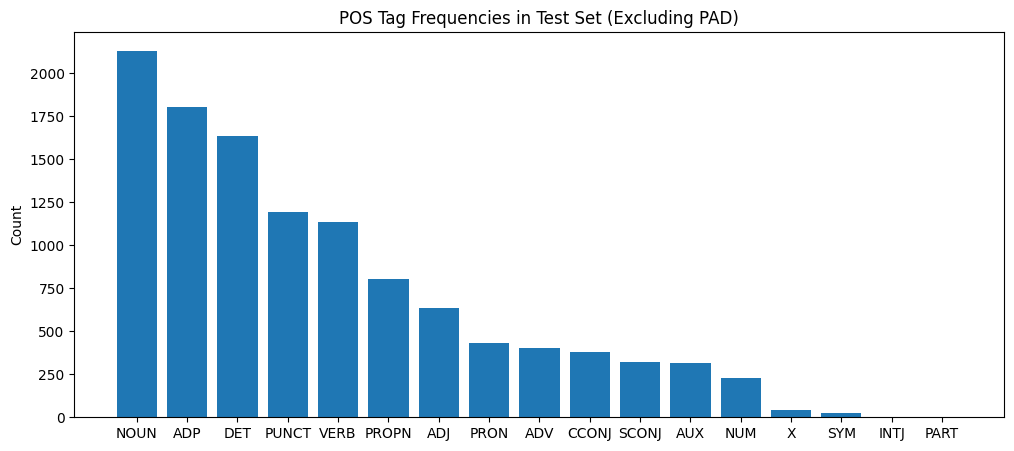

In [14]:
from collections import Counter

all_tags = [tag for seq in test_tags for tag in seq if tag != PAD_TAG]
tag_counts = Counter(all_tags)

tags, counts = zip(*tag_counts.most_common())
plt.figure(figsize=(12,5))
plt.bar(tags, counts)
plt.title("POS Tag Frequencies in Test Set (Excluding PAD)")
plt.ylabel("Count")
plt.show()